In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 21
matplotlib.rcParams['savefig.facecolor'] = 'white'

import pandas as pd
import numpy as np

import skspatial as sks
from skspatial.objects import Line, Points

from datetime import date
import os

In [2]:
hoy = date.today().strftime('%d%m%Y')
path_graf = f'graf_{hoy}'
if not os.path.exists(path_graf):
    os.mkdir(path_graf)
    print(f'CREADO {path_graf}')
else:
    print(f'YA EXISTE {path_graf}')

YA EXISTE graf_07032022


In [3]:
dfc = pd.read_excel('df_cluster_2022-02-25.xlsx')
dfc.head()

,YEAR,ELEVATION,DDD,ECU_DIAM,LON_DIAM,km,pam,clara,jer,fuz,mod
0,2009,2170,70,2.0,2.7,2,1,1,1,1,2
1,2009,2170,70,1.6,2.0,2,1,2,2,1,1
2,2009,2170,70,2.0,2.7,2,1,1,1,1,2
3,2009,2170,70,1.6,2.1,2,1,2,2,1,1
4,2009,2170,70,1.8,2.5,2,1,2,1,1,2


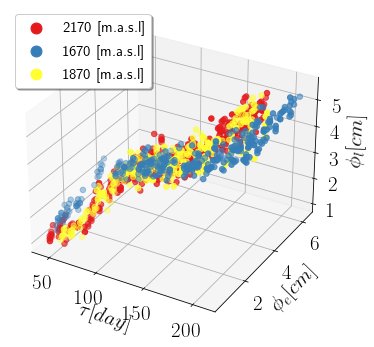

In [4]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

mi_color = {
    2170: '#E41A1C',
    1670: '#377EB8',
    1870: '#FFFF33'
}

for i in dfc['ELEVATION'].unique():
    dff = dfc[dfc['ELEVATION'] == i]
    ax.scatter(
        dff['DDD'], dff['ECU_DIAM'], dff['LON_DIAM'],
        label=f'{i} [m.a.s.l]', c=mi_color.get(i), s=30
    )

ax.set_xlabel(r'$\tau [day]$')
ax.set_ylabel(r'$\phi_{e} [cm]$')
ax.set_zlabel(r'$\phi_{l} [cm]$')

ax.grid(True)
ll = ax.legend(loc=2, prop={'size': 15}, shadow=True, markerscale=2)
# ll.get_frame().set_facecolor('#00FFCC')

plt.savefig(f'{path_graf}/data_by_elevation.png')

In [5]:
import plotly.express as px

fig = px.scatter_3d(dfc, x='DDD', y='ECU_DIAM', z='LON_DIAM', color='ELEVATION')
fig.update_traces(marker_size=3)
fig.show()

In [6]:
def f_fit(obs, lfit):
    obs = np.array(obs)
    p = lfit.point
    v = lfit.vector
    t = (obs[:,0]-p[0])/v[0]
    f = p+[ti*v for ti in t]
    r = f - obs

    d = obs-p # Desviaciones
    num = [d[i,1]*v[2] - d[i,2]*v[1] for i in range(len(d))]
    denom = np.sqrt(1-v[0]**2)
    dist = np.abs(num)/denom
    rmse = np.sqrt(sum(dist**2)/len(dist))

    return f, r, rmse

In [7]:
# cluster: km, pam, clara, jer, fuz, mod

def f_ajuste_dfc(data, method, group, plot = True):
    variables = ['DDD','ECU_DIAM','LON_DIAM']
    p_obs = np.array(data[variables][data[method] == group])
    l_fit = Line.best_fit(p_obs)
    p_fit, res, rmse = f_fit(p_obs, l_fit)
    
    if plot:
        sks.plotting.plot_3d(
            l_fit.plotter(t_1=-80, t_2=80, c='k'),
            # Points(p_fit).plotter(c='r', depthshade=True),
            Points(p_obs).plotter(c='#aaa', depthshade=True)
        )
        ll = ax.legend(loc=2, shadow=True, markerscale=2)
        plt.title(f'{method} - rmse: {round(rmse, 2)}')

    return p_obs, p_fit, res, rmse, l_fit

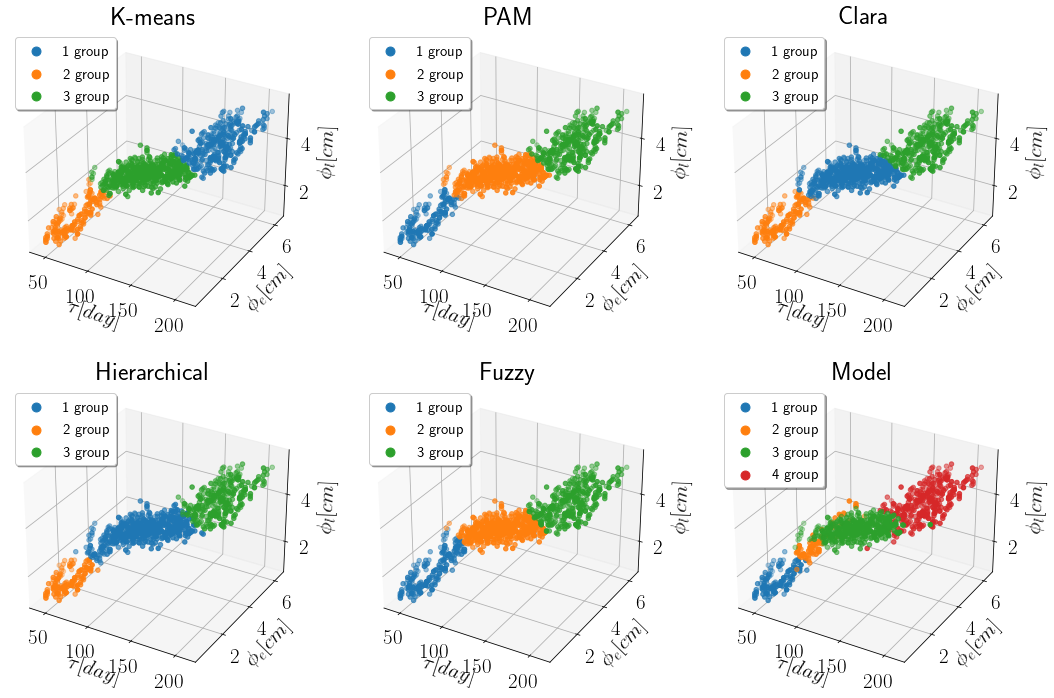

In [8]:
fig = plt.figure(figsize=(18,12))

metod = ['km', 'pam', 'clara', 'jer', 'fuz', 'mod']
metod_name = ['K-means', 'PAM', 'Clara', 'Hierarchical', 'Fuzzy', 'Model']
grupo = [3, 2, 1, 1, 2, 3]

for plot_i in range(6):

    ax = fig.add_subplot(2, 3, plot_i+1, projection='3d')
    mi = metod[plot_i]
    
    for gi in np.sort(dfc[mi].unique()):
        dff = dfc[dfc[mi] == gi]
        ax.scatter(
            dff['DDD'], dff['ECU_DIAM'], dff['LON_DIAM'],
            label=f'{gi} group'
        )

    ax.set_title(metod_name[plot_i])
    ax.set_xlabel(r'$\tau [day]$')
    ax.set_ylabel(r'$\phi_{e} [cm]$')
    ax.set_zlabel(r'$\phi_{l} [cm]$')

    ax.grid(True)
    ll = ax.legend(loc=2, prop={'size': 15}, shadow=True, markerscale=2)
    
plt.savefig(f'{path_graf}/scatter_of_cluster.png')

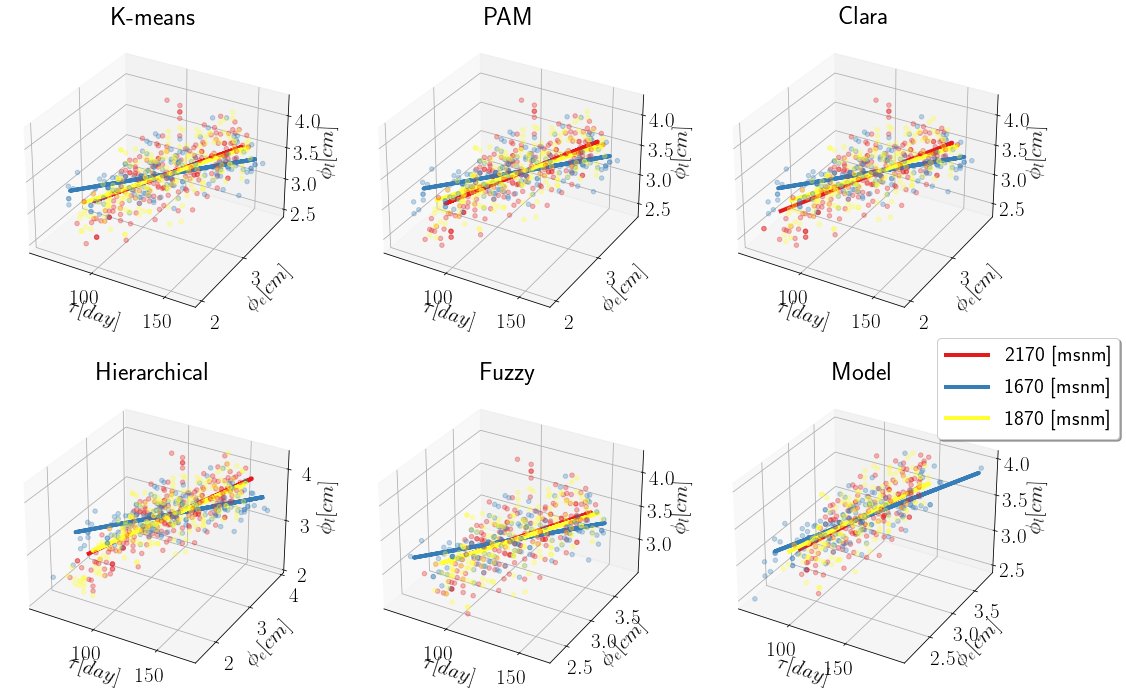

In [9]:
fig = plt.figure(figsize=(18,12))

metod = ['km', 'pam', 'clara', 'jer', 'fuz', 'mod']
metod_name = ['K-means', 'PAM', 'Clara', 'Hierarchical', 'Fuzzy', 'Model']
grupo = [3, 2, 1, 1, 2, 3]
mi_color = {
    2170: '#E41A1C',
    1670: '#377EB8',
    1870: '#FFFF33'
}

for plot_i in range(6):

    ax = fig.add_subplot(2, 3, plot_i+1, projection='3d')
    mi = metod[plot_i]
    gi = grupo[plot_i]
    dfc_grupo = dfc[dfc[mi] == gi]
    
    for alt in dfc_grupo['ELEVATION'].unique():
        dfc_alt = dfc_grupo[dfc_grupo['ELEVATION']==alt]
        ca1 = f_ajuste_dfc(dfc_alt, mi, gi, False)
        ax.scatter(
            dfc_alt['DDD'], dfc_alt['ECU_DIAM'], dfc_alt['LON_DIAM'],
            alpha = 0.3, c=mi_color[alt]
        )
        ax.plot(
            ca1[1][:, 0], ca1[1][:, 1], ca1[1][:, 2],
            label=f'{alt} [msnm]',  c=mi_color[alt], linewidth=4
        )

    # if pi == 6:
    ax.set_title(metod_name[plot_i])
    ax.set_xlabel(r'$\tau [day]$')
    ax.set_ylabel(r'$\phi_{e} [cm]$')
    ax.set_zlabel(r'$\phi_{l} [cm]$')

    
    ax.grid(True)
    if plot_i+1 == 6:
        # ax.legend(loc='lower center')
        ax.legend(bbox_to_anchor=(1.4, 1.2), shadow=True)
        
plt.savefig(f'{path_graf}/lines_of_cluster.png')